## Cost effective GANs training with Amazon SageMaker Spot Instances

This notebook downloads de MNIST digits dataset and uploads it to S3. Then, it launches a script that trains a GAN on the dataset. The training will be done using AWS Sagemaker spot instances.

In [24]:
import os
import numpy as np
import sys
import random
import sagemaker
import boto3
import datetime
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

from sagemaker.session import s3_input
from sagemaker.debugger import TensorBoardOutputConfig
from sagemaker.tensorflow import TensorFlow

We first get some information about the current AWS Session

In [25]:
session = boto3.Session()
sage_client   = session.client('sagemaker')
s3 = boto3.client('s3')
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=session)

print(f"Executing with role: {role}")

Executing with role: arn:aws:iam::182082498060:role/service-role/AmazonSageMaker-ExecutionRole-20200212T153098


Then, we initialize some variables we will use in the notebook

In [26]:
#Sagemaker is kind enough to create a bucket for us
bucket_name = sagemaker_session.default_bucket()
prefix = "mnist-gan"
job_folder      = 'jobs'
dataset_folder  = 'mnist_dataset'
output_path = f's3://{bucket_name}/jobs'
dataset = 'mnist.npy'
output_path = f's3://{bucket_name}/jobs'

print(f"Bucket name: {bucket_name}")

Bucket name: sagemaker-eu-west-1-182082498060


Download MNIST dataset and upload it to S3

In [27]:
(x_train, y_train), (x_test, y_test) = load_data()

#We join the training and test datasets as we are training a GAN
full_dataset = np.vstack((x_train, x_test))

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

#We save the dataset and upload it to S3
np.save(f"{dataset_folder}/{dataset}", full_dataset)
print(f"Train shape {x_train.shape}, {y_train.shape}")
print(f"Test shape {x_test.shape}, {y_test.shape}")
print(f"Full shape {full_dataset.shape}")

train_path = sagemaker_session.upload_data(f"{dataset_folder}/{dataset}", key_prefix=prefix+"/training")
print(f"The dataset was uploaded to: {train_path}")

Train shape (60000, 28, 28), (60000,)
Test shape (10000, 28, 28), (10000,)
Full shape (70000, 28, 28)
The dataset was uploaded to: s3://sagemaker-eu-west-1-182082498060/mnist-gan/training/mnist.npy


We plot some examples so we have an idea of what kind of images will we generate

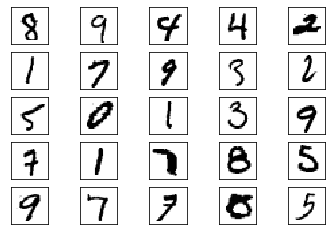

In [28]:
def plot_examples(full_dataset):
    '''
        This function plots 25 examples from the full MNIST dataset.
        full_dataset's shape must be (n_samples, width, height, 1)
    '''
    fig, ax = plt.subplots(5, 5)
    for i in range(5):
        for j in range(5):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(full_dataset[random.randint(0,full_dataset.shape[0] - 1),:,:,0], cmap='gray_r')
            
plot_examples(np.expand_dims(full_dataset, axis=-1))

As we need to install a third part library (matplotlib), we must use a shellscript to install it and then launch the training script. We then will instruct the Sagemaker SDK to launch this shellscript.

In [29]:
%%writefile launcher.sh 

pip install matplotlib

#The hiperparameters are passed as environment variables to this shellscript, we forward them to the python training script
python mnist_gan.py --epochs $SM_HP_EPOCHS --batch_size $SM_HP_BATCH_SIZE --learning_rate $SM_HP_LEARNING_RATE --latent_dim $SM_HP_LATENT_DIM --job_name $SM_HP_JOB_NAME

Overwriting launcher.sh


We need to specify a job name and the training script's hyperparameters. These parameters are clearly not enough to have flexibility in the GAN training, the idea of this notebook is only to show how to train a GAN with AWS Sagemaker Spot Instances. How to properly design a GAN is outside the scope of this notebook.

In [30]:
job_name    = f'gan-spot-{datetime.datetime.now().strftime("%Y-%m-%d-%H%M")}'
hyperparams={'epochs'       : 10,
             'learning_rate': 0.0002, #Learning rate for the discriminator and the generator
             'batch_size'   : 32,
             'latent_dim'   : 256,
             'job_name'     : job_name}

We must create a Tensorflow estimator. Some notable parameters are:
- **train_instance_type**: Instance type that in which the training will be done. The list of available instance types for AWS Sagemaker is here: [AWS Sagemaker Available Instance Types](https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-available-instance-types.html). **Important**: To use some of the types (P family for example) you may need to open a support ticket.
- **train_instance_count**: Number of instances in which the training script will be executed.
- **framework_version**: Tensorflow framework version to use.
- **script_mode**: We set this to true to indicate that we will train the model using a custom script.
- **train_use_spot_instances**: We set this to true to indicate that we will use spot instances.
- **train_max_wait**:  Timeout in seconds waiting for spot training instances (default: None). After this amount of time Amazon SageMaker will stop waiting for Spot instances to become available (default:None).
- **train_max_run**: Timeout in seconds for training (default: 24 * 60 * 60). After this amount of time Amazon SageMaker terminates the job regardless of its current status.

In [31]:
tb_config   = TensorBoardOutputConfig(output_path)

entry_point='launcher.sh'
dependencies=['mnist_gan.py'] #We add the training script as a dependency for the launcher script
tf_estimator = TensorFlow(entry_point=entry_point,
                            dependencies=dependencies,
                            output_path = f'{output_path}/',
                            checkpoint_s3_uri = f'{output_path}/{job_name}/checkpoints',
                            train_instance_type='ml.p3.2xlarge', #ml.p2.xlarge o ml.p3.2xlarge
                            train_instance_count=1,
                            role=sagemaker.get_execution_role(),
                            framework_version='2.1',
                            py_version='py3',
                            script_mode=True,
                            train_use_spot_instances = True,
                            train_max_wait = 7200,
                            train_max_run = 3600,
                            sagemaker_session = sagemaker_session,
                            hyperparameters = hyperparams,
                            tensorboard_output_config= tb_config)


We call the estimator's fit method to run the training script.

In [32]:
tf_estimator.fit({'train'  : train_path}, #dataset path
                  job_name    = job_name,
                  wait        = True) #wait is set to True to indicate that we will wait for the results, 
                                      #if we want an asynchronous execution we must set it to False

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-13 08:46:35 Starting - Starting the training job...
2020-11-13 08:46:37 Starting - Launching requested ML instances......
2020-11-13 08:47:40 Starting - Preparing the instances for training.........
2020-11-13 08:49:14 Downloading - Downloading input data...
2020-11-13 08:49:38 Training - Downloading the training image...
2020-11-13 08:50:16 Training - Training image download completed. Training in progress.2020-11-13 08:50:19,778 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-11-13 08:50:20,301 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch_size": 32,
        "job_name": "gan-spot-2020-11-13-0846",
 

## Saving the resulting model in Tensorflow lite format

Since we will use Tensorflow lite to make the inferences, we must take the resulting model and save it in TF lite format.

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model

The resulting model was saved to S3 in a tar gz file, so we download it and extract it.

In [20]:
model_key = f"jobs/{job_name}/output/model.tar.gz"
s3 = boto3.resource('s3')
try:
    s3.Bucket(bucket_name).download_file(model_key, "model.tar.gz")
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

NameError: name 'job_name' is not defined

In [21]:
!tar xvzf model.tar.gz

tar (child): model.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


Lastly, we convert the model to TF lite format and clean the environment.

In [22]:
k_model = load_model("g_final_model.h5")
tf.saved_model.save(k_model, "gen")
converter = tf.lite.TFLiteConverter.from_saved_model("gen/")
tfmodel = converter.convert()
open("model.tflite" , "wb").write(tfmodel)

OSError: SavedModel file does not exist at: g_final_model.h5/{saved_model.pbtxt|saved_model.pb}

In [23]:
!rm model.tar.gz g_final_model.h5

rm: cannot remove ‘model.tar.gz’: No such file or directory
rm: cannot remove ‘g_final_model.h5’: No such file or directory
